# Drought hazard team output processing

In [1]:
import sys
import os
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
sys.path.append('/g/data/mn51/users/jb6465/drought-github/submodules/gwls')
from gwl import get_GWL_timeslice
sys.path.append('/g/data/mn51/users/jb6465/drought-github/percentiles_spi_spei_smi')
import utils

### GWL slicing

In [2]:
# GWL slicing git hash
import subprocess

def get_submodule_hash(submodule_path):
    result = subprocess.run(['git', '-C', submodule_path, 'rev-parse', 'HEAD'], 
                            capture_output=True, text=True, check=True)
    return result.stdout.strip()

# Example usage
submodule_path = '/g/data/mn51/users/jb6465/drought-github/submodules/gwls'
commit_hash = get_submodule_hash(submodule_path)
print(f"Submodule commit hash: {commit_hash}")

Submodule commit hash: 40fe88fca1eaab8491bb3a5b99167db817b24c65


In [3]:
input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_spi_5km/full_period/'
output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_spi_5km/GWLs/'

files = []
files.extend(sorted(glob.glob("{}/*{}".format(input_dir, '.nc'))))

for input_file in files:
    print(f"---> GWL slicing for {input_file.rpartition('/')[-1]}")
    model_list = ['CMCC-ESM2','ACCESS-ESM1-5','ACCESS-CM2','EC-Earth3','CESM2','CNRM-ESM2-1','MPI-ESM1-2-HR', 'NorESM2-MM'] 
    target_model = [model for model in model_list if model in input_file][0]
    variant_id = utils.data_source['CMIP6'][target_model]['variant-id']
    for GWL in [1.2, 1.5, 2.0, 3.0]:
        print('= GWL'+str(GWL))
        GWL_timeslice = get_GWL_timeslice(xr.open_dataset(input_file),'CMIP6',target_model,variant_id,'ssp370',GWL)

        # write to netcdf in output_dir
        GWL_timeslice.attrs['description'] = f"Standardised Precipitation Index computed using method of McKee et al. 1993 for {target_model} GWL{str(GWL)} using a base period of 1965-2014. Further details in supporting technical documentation."
        GWL_timeslice.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
        GWL_timeslice.attrs['comment'] = f"Using data on {input_dir}"
        GWL_timeslice.attrs['GWL'] = f"GWL {str(GWL)}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
        GWL_timeslice.to_netcdf(f"{output_dir}{input_file.rpartition('/')[-1][:-3]}_GWL{str(GWL)}.nc")

---> GWL slicing for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_CSIRO_v1-r1_baseperiod19652014.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_CESM2_ssp370_r11i1p1f1_BOM_v1-r1_baseperiod19652014.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_CESM2_ssp370_r11i1p1f1_CSIRO_v1-r1_baseperiod19652014.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_CMCC-ESM2_ssp370_r1i1p1f1_BOM_v1-r1_baseperiod19652014.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_CMCC-ESM2_ssp370_r1i1p1f1_CSIRO_v1-r1_baseperiod1965

### Percent time below SPI < -1

In [103]:
SPI_threshold = -1
input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/GWLs/'
output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*{}".format(input_dir, '.nc'))))

In [104]:
print(f"Computing pct time below -1")
for spi_file in files:
    print(f"-> for {spi_file.rpartition('/')[-1]}")
    spi_xr = xr.open_dataset(spi_file)
    pct_below_thresh = 100*((spi_xr.SPI3)<=SPI_threshold).sum(dim='time')/len(spi_xr.SPI3.time)
    
    # write to netcdf in output_dir
    pct_below_thresh.attrs['description'] = f"Standardised Precipitation Index percent of months below -1 for input file: {spi_file.rpartition('/')[-1]} in {input_dir}. "
    pct_below_thresh.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
    pct_below_thresh.attrs['GWL'] = f"GWL {spi_file[-6:-3]}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
    pct_below_thresh.to_netcdf(f"{output_dir}{(spi_file.rpartition('/')[-1][:-3])[:5]+'pct_time_below_-1'+(spi_file.rpartition('/')[-1][:-3])[4:]}.nc", mode='w')

Computing pct time below -1
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL1.2.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL1.5.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL2.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL3.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_GWL1.2.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_GWL1.5.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_GWL2.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_GWL3.0.nc
-> for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014_GWL1.2.nc
-> for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014_GWL1.5.nc
-> for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014_GWL2.0.n

### 10-50-90 Percentiles for GWL and change between GWLs

In [299]:
input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'
output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*pct_time_below*baseperiod19652014*{}".format(input_dir, '.nc'))))

In [300]:
files

['/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL1.5.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL2.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_GWL3.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_GWL1.5.nc',
 '/g/data/ia39/ncra/drought_ar

In [282]:
for GWL in [1.2, 1.5, 2.0, 3.0]:
    print(f"Computing MME 10-50-90th percentiles for GWL{str(GWL)}")
    GWL_file_list = [file for file in files if f"GWL{str(GWL)}" in file]
    GWL_ens_list = [file[91:-35] for file in files if f"GWL{str(GWL)}" in file]
    MME_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL_file_list, GWL_ens_list)], dim='MME')
    
    p10_50_90_xr = MME_xr.quantile([0.1,0.5,0.9], dim ='MME')
    p10_50_90_xr.attrs['description'] = f"MME 10th, 50th and 90th percentile of pct of months below Standardised Precipitation Index of -1. "
    p10_50_90_xr.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
    p10_50_90_xr.attrs['GWL'] = f"GWL {str(GWL)}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
    p10_50_90_xr.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
    p10_50_90_xr.to_netcdf(f"{output_dir}SPI3_pct_time_below_-1_GWL_{str(GWL)}_percentiles_10-50-90.nc", mode='w')

    #10-50-90th percentile of percent change for each ensemble 
    if GWL != 1.2:
        print(f"---> Computing MME change 10-50-90th percentiles for GWL{str(GWL)} and GWL1.2")
        GWL12_file_list = [file for file in files if "GWL1.2" in file]
        GWL12_ens_list = [file[91:-35] for file in files if "GWL1.2" in file]
        MME_GWL12_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL12_file_list, GWL12_ens_list)], dim='MME')
            
        MME_change_p10_50_90 = (MME_xr-MME_GWL12_xr).quantile([0.1,0.5,0.9], dim ='MME')
        MME_change_p10_50_90.attrs['description'] = f"MME change between GWL{str(GWL)} and GWL1.2 for 10th, 50th and 90th percentile of pct of months below Standardised Precipitation Index of -1. "
        MME_change_p10_50_90.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
        MME_change_p10_50_90.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
        MME_change_p10_50_90.to_netcdf(f"{output_dir}SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc", mode='w')

Computing MME 10-50-90th percentiles for GWL1.2
Computing MME 10-50-90th percentiles for GWL1.5
---> Computing MME change 10-50-90th percentiles for GWL1.5 and GWL1.2
Computing MME 10-50-90th percentiles for GWL2.0
---> Computing MME change 10-50-90th percentiles for GWL2.0 and GWL1.2
Computing MME 10-50-90th percentiles for GWL3.0
---> Computing MME change 10-50-90th percentiles for GWL3.0 and GWL1.2


GWL1.5-GWL1.2


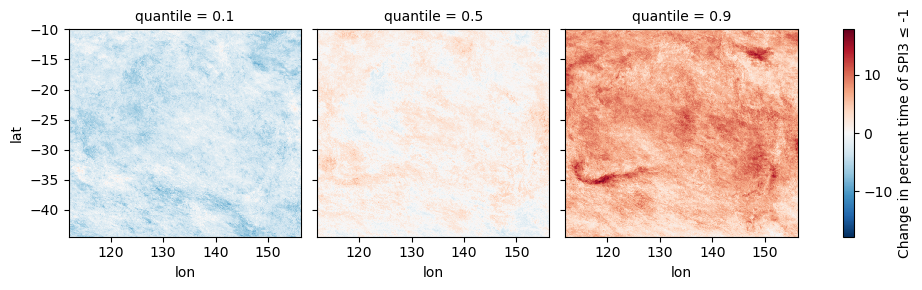

GWL2.0-GWL1.2


<Figure size 640x480 with 0 Axes>

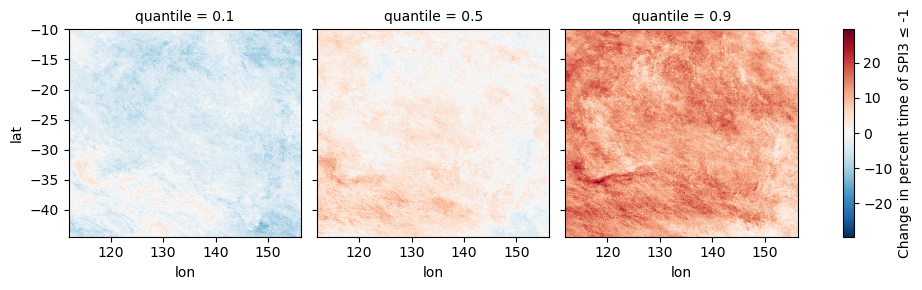

GWL3.0-GWL1.2


<Figure size 640x480 with 0 Axes>

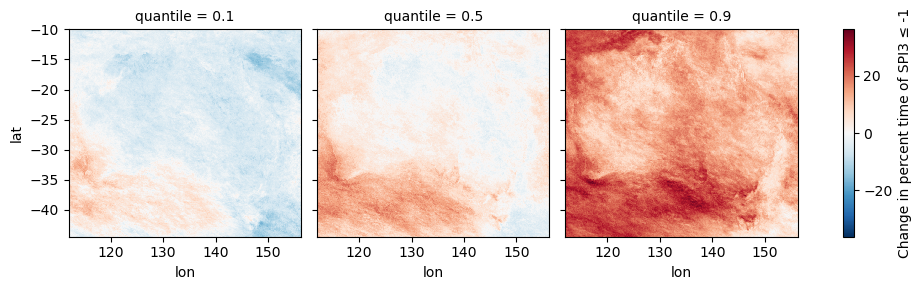

<Figure size 640x480 with 0 Axes>

In [362]:
#quick check of outputs
for GWL in [1.5, 2.0, 3.0]:
    print(f"GWL{str(GWL)}-GWL1.2")
    quick_check_ds = xr.open_dataset(f"/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc")
    quick_check_ds.SPI3.plot(col="quantile",cmap="RdBu_r", cbar_kwargs={'label': 'Change in percent time of SPI3 ≤ -1'})
    plt.show()
    plt.clf()

### Plotting

In [328]:
cd /g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps


In [329]:
from acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict, tick_dict

In [ ]:
## not sure why the change plots take ~7 mins to plot :(

CPU times: user 8min 24s, sys: 649 ms, total: 8min 25s
Wall time: 8min 24s


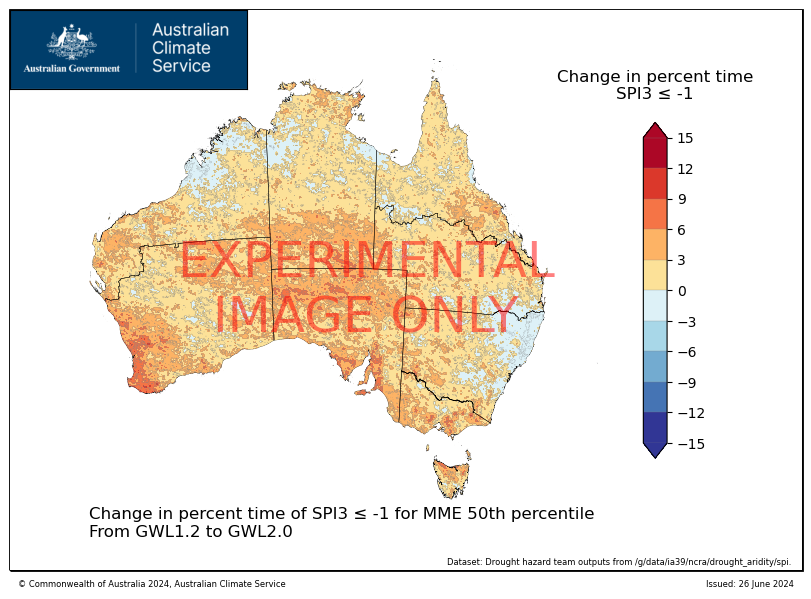

In [363]:
%%time
plot_file = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_MME_change_GWL2.0_to_GWL1.2_percentiles_10-50-90.nc'
percentile = 0.5

plot_acs_hazard(data = xr.open_dataset(plot_file).sel(quantile=percentile).SPI3,
                regions = regions_dict['ncra_regions'],
                cmap = cmap_dict["anom_b2r"],
                ticks = np.arange(-15, 15.1, 3),
                cbar_label = "Change in percent time\nSPI3 ≤ -1",
                cbar_extend = "both",
                title = f"Change in percent time of SPI3 ≤ -1 for MME {str(int(percentile*100))}th percentile",
                dataset_name = "Drought hazard team outputs from /g/data/ia39/ncra/drought_aridity/spi. ",
                date_range = f"From GWL1.2 to {plot_file[-40:-34]}",
               );

CPU times: user 1min, sys: 91.6 ms, total: 1min
Wall time: 1min 2s


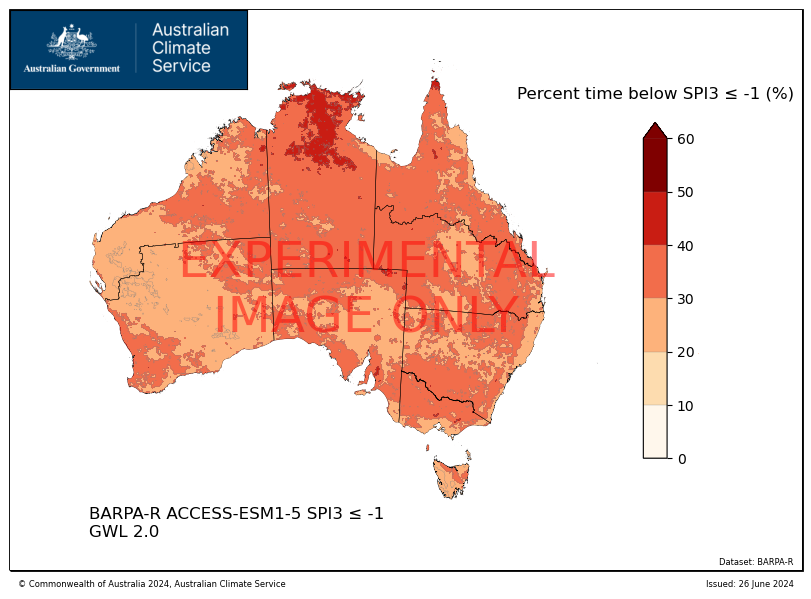

In [346]:
%%time
plot_acs_hazard(data = xr.open_dataset('/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014_GWL2.0.nc').SPI3,
                    regions = regions_dict['ncra_regions'],
                    cmap = cmap_dict["OrRd"],
                    ticks = np.arange(0, 60.1, 10),
                    cbar_label = "Percent time below SPI3 ≤ -1 (%)",
                    cbar_extend = "max",
                    title = "BARPA-R ACCESS-ESM1-5 SPI3 ≤ -1",
                    dataset_name = "BARPA-R",
                    date_range = "GWL 2.0",
                   );

CPU times: user 13.8 s, sys: 48.2 ms, total: 13.9 s
Wall time: 13.9 s


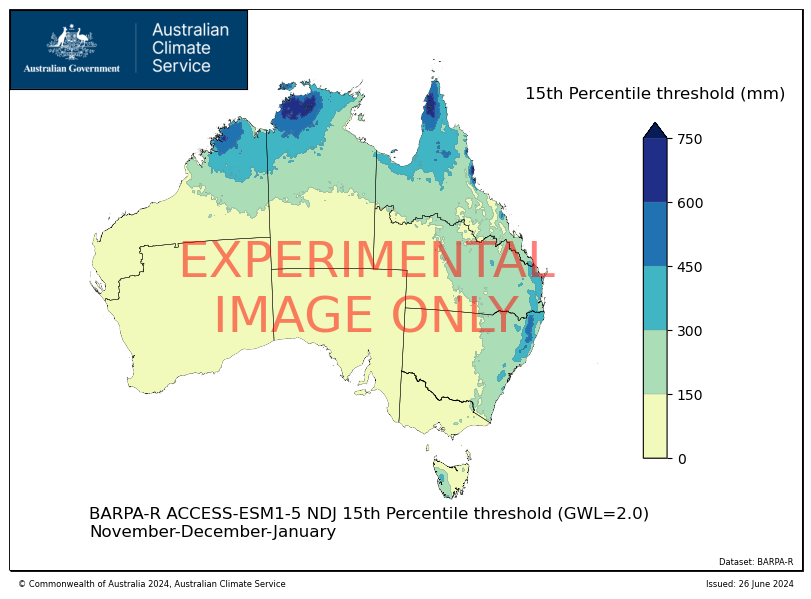

In [306]:
%%time
plot_acs_hazard(data = xr.open_dataset('/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/p15_3month_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_GWL2.0.nc').sel(month='DJF').p15_3month,
                    regions = regions_dict['ncra_regions'],
                    cmap = cmap_dict["pr"],
                    ticks = None,
                    cbar_label = "15th Percentile threshold (mm)",
                    cbar_extend = "max",
                    title = "BARPA-R ACCESS-ESM1-5 NDJ 15th Percentile threshold (GWL=2.0)",
                    dataset_name = "BARPA-R",
                    date_range = "November-December-January",
                   );